# TLS Experiments of UA Q4

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script, CompilerOptionArguments
from qm.octave import *
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qm.octave import QmOctaveConfig
from quam import QuAM

from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
#from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber
import xarray as xr

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 0 # for UA Q4
TLS_index = 3 # for TLS of interest
dc_flux_index = 3 # for dc line

2024-07-17 14:52:25,616 - qm - INFO     - Starting session: 441a1194-674e-475a-9c84-4a47951a9ae0


In [2]:
Analysis = AnalysisHandle("quam_state_q3.json")
machine = Analysis.get_machine()
Experiment = ExperimentHandle(machine)

In [3]:
# initialize Labber-controlled hardware
# get values from QDAC first
#machine = Experiment.set_Labber.get_value_from_QDAC(machine)
# set all Labber settings
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
# set octave to external clock
Experiment.set_octave.set_clock(machine)

------------Octave set to External_10MHz


In [4]:
# set for the qubit
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q3 for (LO, IF) = (5.954 GHz, -50.000 MHz)
------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


# TLS Characterizations

In [5]:
TLS_index = 3

## TLS T1 (swap)

In [6]:
%matplotlib qt
tau_sweep_abs = np.arange(20,7500E3+1,5E5)
machine, expt_dataset = Experiment.exp1D.T1.TLS_T1(machine, tau_sweep_abs, qubit_index, TLS_index,
                   n_avg = 1E4, cd_time_qubit = 25E3, cd_time_TLS = 7500E3, live_plot = True, data_process_method = 'I')

Execution stopped by user!                                   ] 1.7% (n=170/10000.0) --> elapsed time: 27.57s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0717\2024-07-17_q3t3_tls_T1_swap0.0) --> elapsed time: 27.88s


Qubit T1: 2522.7 [us]


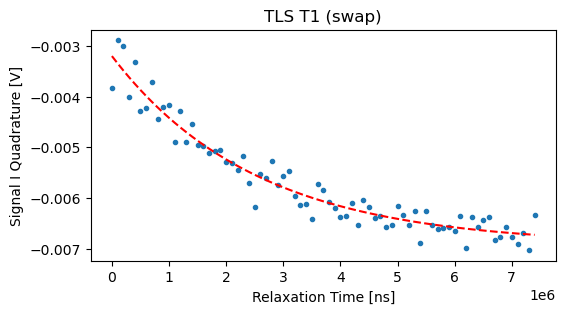

In [25]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(expt_dataset, data_process_method = 'I')

# TLS Driving Pulses

## set rf_gain for TLS pulse

In [140]:
machine.octaves[0].LO_sources[1].gain = 10
machine = Analysis.set_machine(machine)

## TLS spectroscopy

In [9]:
machine.qubits[qubit_index].pi_amp_tls[TLS_index] *= 5
machine.qubits[qubit_index].pi_length_tls[TLS_index] /= 5
machine = Analysis.set_machine(machine)

In [10]:
%matplotlib qt
TLS_freq_sweep = machine.qubits[qubit_index].f_tls[TLS_index] + np.arange(-10E6,10E6+1, 1E6)
machine, expt_dataset = Experiment.exp1D.Rabi.TLS_freq(machine, TLS_freq_sweep, qubit_index, TLS_index,
                  n_avg = 1E3, cd_time_qubit = 25E3, cd_time_TLS = 7500E3, live_plot = True, data_process_method = 'I')

TLS if range > 400MHz. Setting the octave freq. Will calibrate octave.
------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q3 for (LO, IF) = (4.996 GHz,  50.000 MHz)
------------------------------------- Octave calibration finished.
Execution stopped by user!                                   ] 5.7% (n=57/1000.0) --> elapsed time: 8.32s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0715\2024-07-15_q3t3_tls_spec00.0) --> elapsed time: 8.83s


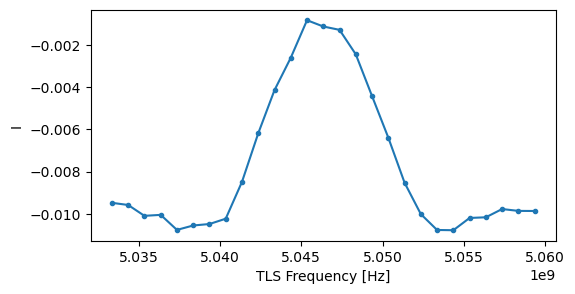

In [11]:
expt_dataset = xr.load_dataset(r'Z:\QM_Data_DF5\2024\07\Data_0709\2024-07-09_q3t3_tls_spec.nc')
expt_dataset['I'].plot(x=list(expt_dataset.coords.keys())[0], marker = '.')

peak frequency:  5046.3 [MHz]


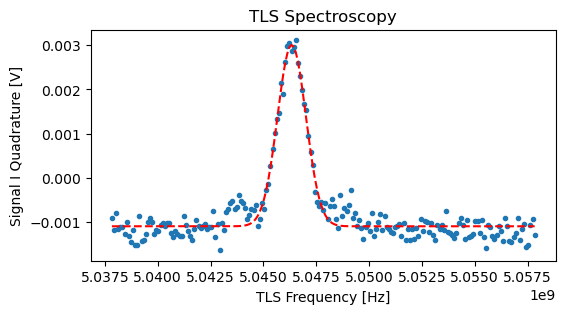

In [8]:
%matplotlib inline
TLS_freq = Analysis.exp1D.peak_fit(expt_dataset, method = "Gaussian", data_process_method = 'I')
machine.qubits[qubit_index].f_tls[TLS_index] = TLS_freq + 0E6
# machine.qubits[qubit_index].f_tls[TLS_index] = 5439.35E6 + 0E6 
machine = Analysis.set_machine(machine)

## TLS spectroscopy with CORPSE

In [18]:
%matplotlib qt
TLS_freq_sweep = machine.qubits[qubit_index].f_tls[TLS_index] + np.arange(-20E6,20E6+1,0.2E6)
#define CORPSE angles 
t1 = 420*np.pi/180
t2 = 300*np.pi/180
t3 = 60*np.pi/180
#transform angles to duration of pulse and amplitude (to deal with the clock cycles)
corpse_tau = [252, 180, 36]
pi_amp_rel = [1, 1, 1 ]
machine, expt_dataset = Experiment.exp1D.Rabi.TLS_freq_corpse(machine, TLS_freq_sweep, qubit_index, TLS_index, corpse_tau = corpse_tau, pi_amp_rel = pi_amp_rel,
                  n_avg = 1E3, cd_time_qubit = 25E3, cd_time_TLS = 7500E3,live_plot = True, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 1511.69s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0702\2024-07-02_q3t3_tls_spec_corpse_13


## TLS rabi

change rf gain of octave

In [126]:
%matplotlib qt
rabi_duration_sweep = np.arange(16, 240 + 0.1, 8)  # in units of ns
machine, expt_dataset = Experiment.exp1D.Rabi.TLS_rabi_length(machine, rabi_duration_sweep, qubit_index, TLS_index,
                      n_avg = 1E3, cd_time_qubit = 25E3, cd_time_TLS = 7500E3, live_plot = True, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 218.35s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0708\2024-07-08_q3t3_tls_time_rabi
Execution stopped by user!


rabi_pi_pulse: 107.6 [ns]
pi period: 107.02 [ns]


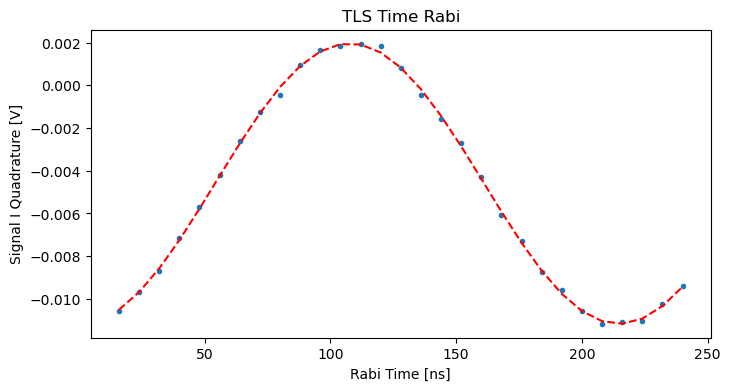

In [129]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(expt_dataset, method = "Sine", to_plot = True, data_process_method = 'I')

In [131]:
machine.qubits[qubit_index].pi_amp_tls[TLS_index] * 107.6 / 108

0.4533027064163201

In [130]:
machine.qubits[qubit_index].pi_amp_tls[TLS_index]

0.45498784658887154

In [132]:
machine.qubits[qubit_index].pi_amp_tls[TLS_index] = 0.4533027064163201
machine.qubits[qubit_index].pi_length_tls[TLS_index] = 108
machine = Analysis.set_machine(machine)

## TLS Ramsey

In [80]:
%matplotlib qt
ramsey_duration_sweep = np.arange(16, 2500 + 0.1, 32)  # in units of ns
machine, expt_dataset = Experiment.exp1D.Ramsey.TLS_ramsey(machine, ramsey_duration_sweep, qubit_index, TLS_index,
                       n_avg = 10E3, detuning = 2E6, cd_time_qubit = 25E3, cd_time_TLS = 7500E3, live_plot = True, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 5871.34s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0701\2024-07-01_q3t3_tls_ramsey_3
Execution stopped by user!


Qubit T2*:  548.7 [ns]
Exponent n =  1.5
Detuning =  2.1 [MHz]


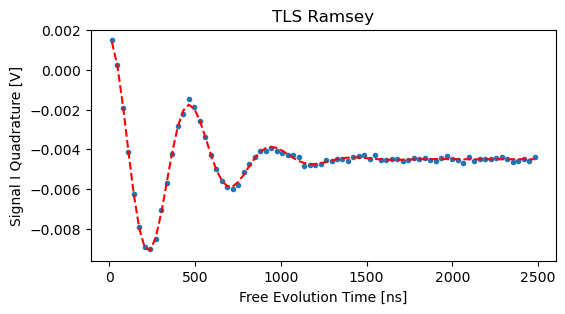

In [82]:
%matplotlib inline
tls_T2star = Analysis.exp1D.ramsey(expt_dataset, data_process_method = 'I')

As a sanity check, run fft, see if there are multiple peaks

In [84]:
%matplotlib qt
fft_dataset = Analysis.exp1D.fft(expt_dataset, data_process_method = 'I')

## TLS T1 with direct driving

In [21]:
%matplotlib qt
tau_sweep_abs = np.arange(20,10000E3+1,5E5)
machine, expt_dataset = Experiment.exp1D.T1.TLS_T1_drive(machine, tau_sweep_abs, qubit_index, TLS_index,
                     n_avg = 1E3, cd_time_qubit = 25E3, cd_time_TLS = 7500E3, live_plot = True, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 295.26s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0629\2024-06-29_q3t3_tls_T1_drive_2
Execution stopped by user!


Qubit T1: 1342.9 [us]


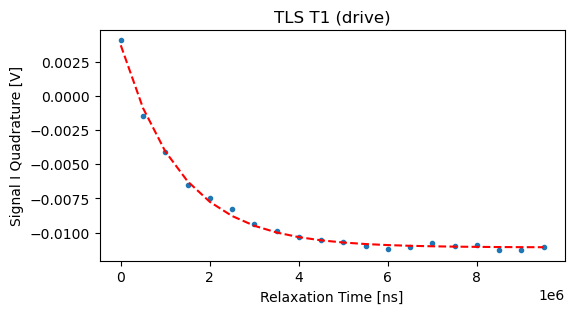

In [23]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(expt_dataset, data_process_method = 'I')

# TLS Dynamical Decoupling

## Longer Timescale Decay

### echo

In [58]:
%matplotlib qt
tau_sweep_abs = np.arange(500, 35E3 + 0.1, 0.8E3)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_echo(machine, tau_sweep_abs, qubit_index, TLS_index, n_avg = 5E3,
                     cd_time_qubit = 25E3, cd_time_TLS = 7500E3, live_plot = True)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1663.30s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0701\2024-07-01_q3t3_tls_echo_2


Qubit T2*:  15.8 [us]
Exponent n =  1.5


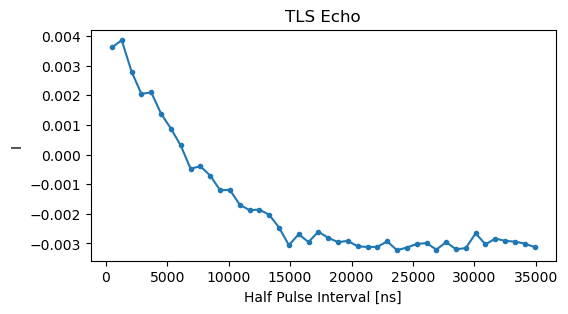

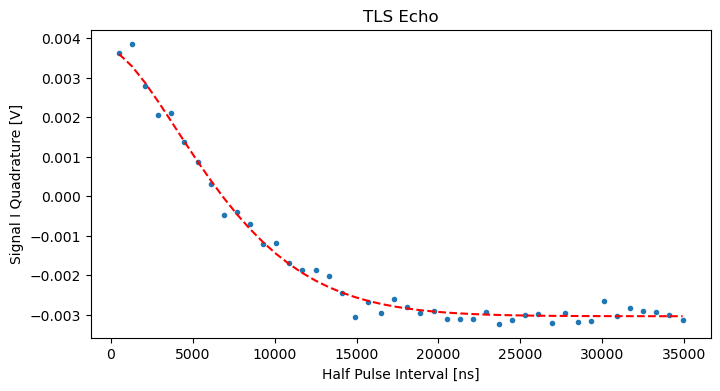

Execution stopped by user!


In [59]:
%matplotlib inline
TLS_T2echo = Analysis.exp1D.T2(expt_dataset, data_process_method = 'I', N_tau =2)

### CPMG-2

In [60]:
%matplotlib qt
N_CPMG = 2
tau_sweep_abs = np.arange(500, 25E3 + 0.1, 0.4E3)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 5E3, cd_time_qubit = 25E3, cd_time_TLS = 7500E3, live_plot = True)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 2348.68s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0701\2024-07-01_q3t3_tls_cpmg2_2


Qubit T2*:  18.1 [us]
Exponent n =  1.5


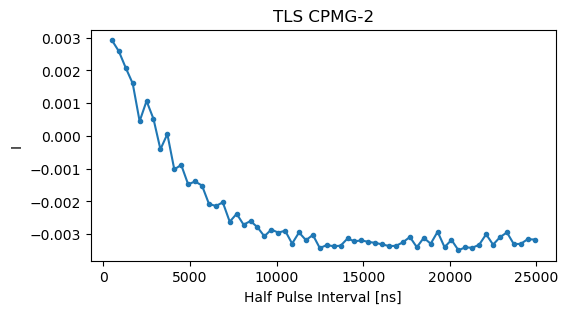

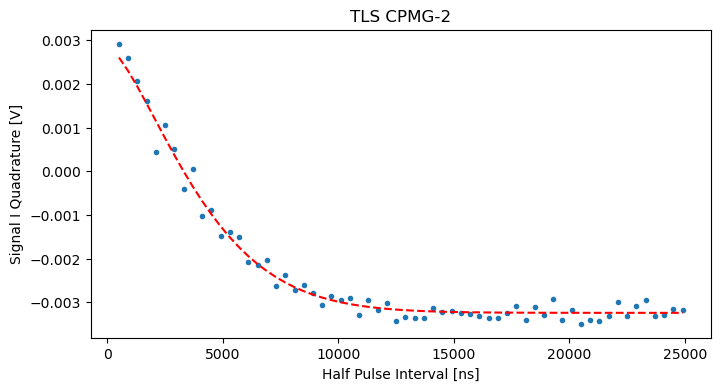

Execution stopped by user!


In [61]:
%matplotlib inline
TLS_T2dd = Analysis.exp1D.T2(expt_dataset, data_process_method = 'I', N_tau = 2 * N_CPMG)

### CPMG-8

In [62]:
%matplotlib qt
N_CPMG = 8
tau_sweep_abs = np.arange(500, 9E3 + 0.1, 0.1E3)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 5E3, cd_time_qubit = 25E3, cd_time_TLS = 7500E3, live_plot = True)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 3268.90s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0701\2024-07-01_q3t3_tls_cpmg8


Qubit T2*:  32.7 [us]
Exponent n =  1.4


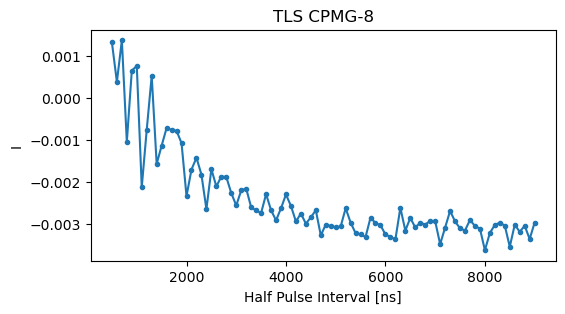

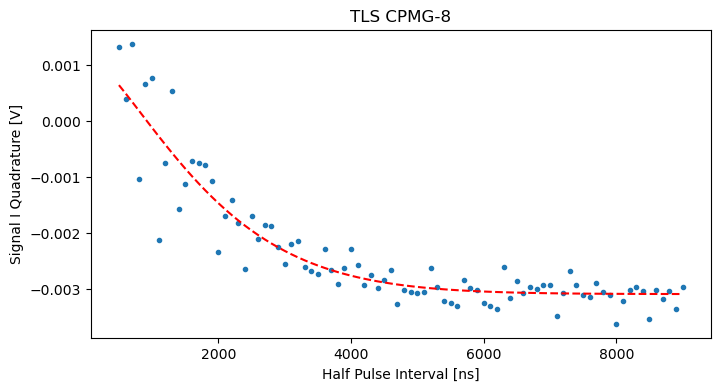

Execution stopped by user!


In [63]:
%matplotlib inline
TLS_T2dd = Analysis.exp1D.T2(expt_dataset, data_process_method = 'I', N_tau = 2 * N_CPMG)

## CPMG-16

In [67]:
%matplotlib qt
N_CPMG = 16
tau_sweep_abs = np.arange(500, 10E3 + 0.1, 0.52E3)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 20E3, cd_time_qubit = 25E3, cd_time_TLS = 7500E3, live_plot = True)

Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 2923.73s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0701\2024-07-01_q3t3_tls_cpmg16_3


Qubit T2*:  41.9 [us]
Exponent n =  3.0


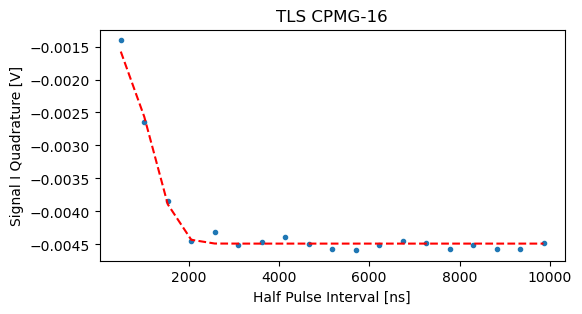

In [69]:
%matplotlib inline
TLS_T2dd = Analysis.exp1D.T2(expt_dataset, data_process_method = 'I', N_tau = 2 * N_CPMG)

## Shorter Timescale Dynamics

### Compute a sweep of different N in CPMG with TLS spectroscopy every x averages

In [109]:

tau_sweep_abs = np.arange(16, 4E3 + 0.1, 12)  # in units of ns
N_CPMG_sweep = np.arange(2, 70+0.1, 2)

n_avg = 20E3 # Number of total averages
delta_avg = 5000 # After this amount of averages run a TLS spectroscopy to make sure the signal has not decayed
cd_time_qubit = 25E3
cd_time_TLS = 7500E3
runs = int(n_avg/delta_avg)

## In order to save the averaged data
expt_qubits = [machine.qubits[qubit_index].name]
expt_TLS = ['t'+str(TLS_index)] 
expt_extra = [ 'n_ave: ' + str(n_avg) + '-' + 'Qubit CD [ns]: ' + str(cd_time_qubit) + '-' + 'TLS CD [ns]: ' + str(cd_time_TLS)] # ALWAYS SEPARATE DIFFERENT ATTRIBUTES WITH A DASH (this is the delimiter)
expt_sequence = """update_frequency(machine.qubits[qubit_index].name, tls_if_freq) # important, otherwise will use the if in configuration, calculated from f_01
with for_(n, 0, n < n_avg, n + 1):
	with for_(*from_array(t, tau_sweep)):
		with strict_timing_():
			if pi_over_2_phase=='x':
				play("pi2_tls", machine.qubits[qubit_index].name)
			else:
				play("pi2y_tls", machine.qubits[qubit_index].name)

			wait(t, machine.qubits[qubit_index].name)

			for i in range(N_CPMG - 1):
				play("pi_tls", machine.qubits[qubit_index].name)
				wait(t * 2, machine.qubits[qubit_index].name)

			play("pi_tls", machine.qubits[qubit_index].name)
			wait(t, machine.qubits[qubit_index].name)

			if pi_over_2_phase=='x':
				play("pi2_tls", machine.qubits[qubit_index].name)
			else:
				play("pi2y_tls", machine.qubits[qubit_index].name)

		align()
		square_TLS_swap[0].run()
		align()
		readout_rotated_macro(machine.resonators[qubit_index].name,I,Q)
		wait(cd_time_qubit * u.ns, machine.resonators[qubit_index].name)
		save(I, I_st)
		save(Q, Q_st)
		align()
		square_TLS_swap[0].run(amp_array=[(machine.flux_lines[qubit_index].name, -1)])
		wait(cd_time_TLS * u.ns, machine.flux_lines[qubit_index].name)
	save(n, n_st)
 NOTE: THE AVERAGES ARE DONE SEQUENTIALLY TO UPDATE THE TLS FREQUENCY IN CASE IT CHANGED"""



for ind, N in enumerate(N_CPMG_sweep):
    N = int(N)
    datasets = []
    print('*****************RUNNING CPMG ', N , '*****************')
    timestamp_created = datetime.datetime.now()
    
    for n in np.arange(runs):
        print('Running average', n+1, 'out of ', runs)
        machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N,
                         n_avg = delta_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, final_plot = False, live_plot = False)
        datasets.append(expt_dataset)
        
        # Run spectroscopy
        print('Running spectroscopy', n+1, 'out of ', runs)
        TLS_freq_sweep = machine.qubits[qubit_index].f_tls[TLS_index] + np.arange(-13E6,13E6+1,1E6)
        machine, expt_dataset_spec = Experiment.exp1D.Rabi.TLS_freq(machine, TLS_freq_sweep, qubit_index, TLS_index,
                          n_avg = 2E3, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, final_plot = False, live_plot = False, data_process_method = 'I')
        
        # Analyze spectrosocpy data to get the newest frequency 
        TLS_freq = Analysis.exp1D.peak_fit(expt_dataset_spec, to_plot= False,  method = "Gaussian", data_process_method = 'I')
        machine.qubits[qubit_index].f_tls[TLS_index] = TLS_freq + 0E6
        machine = Analysis.set_machine(machine)
        print('Set TLS frequency to', TLS_freq)
        
    dataset_tmp = xr.concat(datasets, dim='runs')
    dataset_ave = dataset_tmp.mean(dim='runs')
    timestamp_finished = datetime.datetime.now()
    expt_name = 'tls_cpmg' + str(N_CPMG_sweep[ind])
    expt_long_name = 'TLS CPMG' + '-' + str(N_CPMG_sweep[ind])
    # save data
    expt_dataset = Experiment.datalogs.save(dataset_ave, machine, timestamp_created, timestamp_finished, expt_name, expt_long_name, expt_qubits, expt_TLS, expt_sequence, expt_extra = expt_extra)
    globals()[f'exp_dataset_CPMG_{N}'] = expt_dataset



*****************RUNNING CPMG  2 *****************
Running average 1 out of  4
Progress: [##################################################] 100.0% (n=5000/5000) --> elapsed time: 12542.46s
Progress: [##################################################] 100.0% (n=5000/5000) --> elapsed time: 12542.51s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0703\2024-07-03_q3t3_tls_cpmg2_56
Running spectroscopy 1 out of  4
Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 406.14s
Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 406.19s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0703\2024-07-03_q3t3_tls_spec_45
Set TLS frequency to 5047564209
Running average 2 out of  4
Progress: [##################################################] 100.0% (n=5000/5000) --> elapsed time: 12542.49s
Progress: [##################################################] 100.0% (n=5000/5000) --> elapsed time: 12542

QMTimeoutError: Timeout reached while running 'get_named_header'

### For loop to compute a sweep of different N in CPMG

Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 9948.42s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 9948.46s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0708\2024-07-08_q3t3_tls_cpmg10_2


<Figure size 600x300 with 0 Axes>

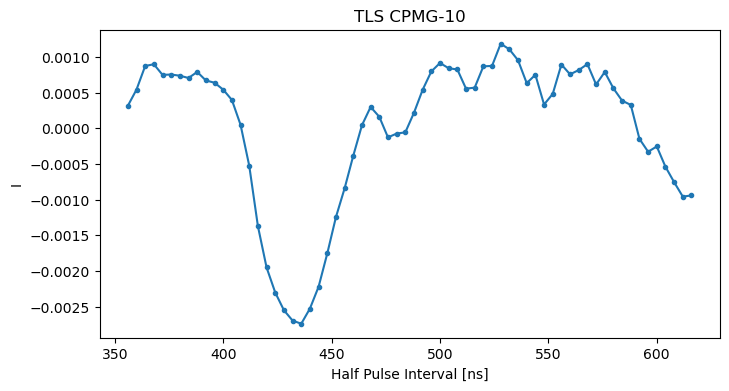

In [133]:
# Do a sweep of several CPMG N 
n_avg = 20E3
cd_time_qubit = 25E3
cd_time_TLS = 7500E3
# tau_sweep_abs = np.arange(16, 4E3 + 0.1, 12)  # in units of ns
# N_CPMG_sweep = np.arange(2, 70+0.1, 2)
tau_sweep_abs = np.arange(358, 620 + 0.1, 4)  # in units of ns
N_CPMG_sweep = [10]
for N in N_CPMG_sweep:
    N = int(N)
    machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N,
                     n_avg = n_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, live_plot = False)

In [134]:
%matplotlib qt
expt_dataset = xr.load_dataset(r'Z:\QM_Data_DF5\2024\07\Data_0708\2024-07-08_q3t3_tls_cpmg10_2.nc')
expt_dataset['I'].plot(x = 'Half_Pulse_Interval')

### CPMG-2

In [ ]:
## test to add single shot measurements interleaved with every measurement data
%matplotlib inline
N_CPMG = 2
tau_sweep_abs = np.arange(20, 2.5E3 + 0.1, 20)  # in units of ns
for 

machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 10E3, cd_time_qubit = 25E3, cd_time_TLS = 7500E3, live_plot = False)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 9413.61s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 9413.65s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0703\2024-07-03_q3t3_tls_cpmg2


<Figure size 600x300 with 0 Axes>

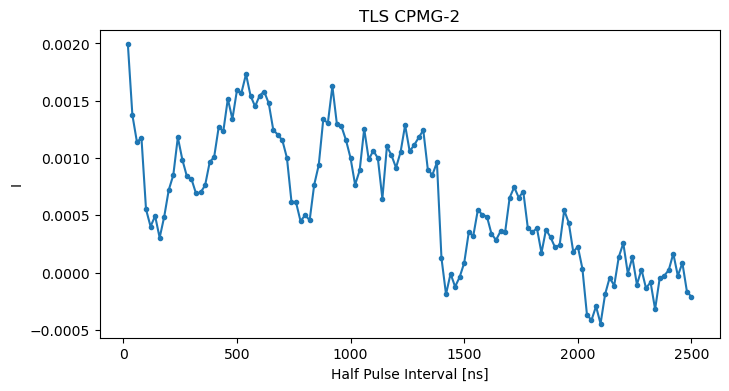

In [81]:
%matplotlib inline
N_CPMG = 2
tau_sweep_abs = np.arange(20, 2.5E3 + 0.1, 20)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 10E3, cd_time_qubit = 25E3, cd_time_TLS = 7500E3, live_plot = False)

### CPMG-4

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 3022.33s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 3022.37s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 3022.41s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 3022.44s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0611\2024-06-11_q3t1_tls_cpmg4


<Figure size 600x300 with 0 Axes>

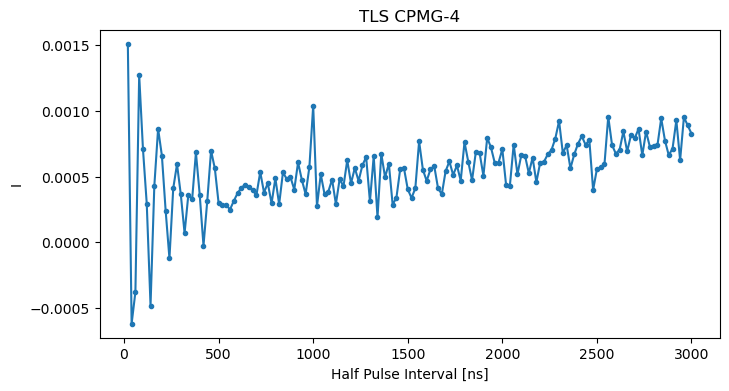

In [49]:
%matplotlib inline
N_CPMG = 4
tau_sweep_abs = np.arange(20, 3E3 + 0.1, 20)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 4E3, cd_time_qubit = 25E3, cd_time_TLS = 5000E3, live_plot = False)

In [ ]:
%matplotlib inline
expt_dataset = xr.load_dataset(r"Z:\QM_Data_DF5\2024\05\Data_0520\2024-05-20_q1t1_tls_cpmg4.nc")
expt_dataset['I'].plot(x=list(expt_dataset.coords.keys())[0], marker = '.')
plt.title(expt_dataset.attrs['long_name'])

### CPMG-8

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 324.08s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 324.11s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 324.15s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 324.19s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0607\2024-06-07_q1t0_tls_cpmg8_5


<Figure size 800x400 with 0 Axes>

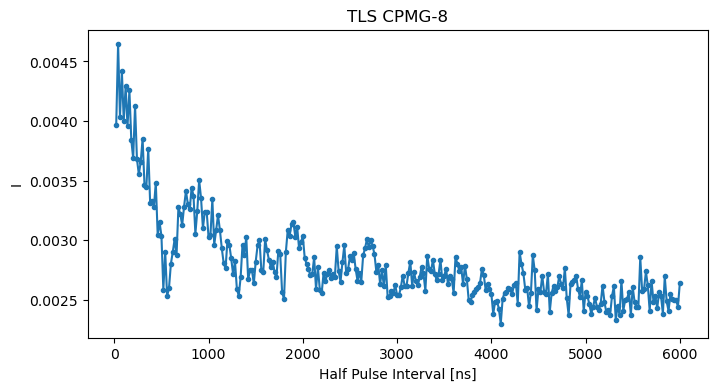

In [171]:
%matplotlib inline
N_CPMG = 8
tau_sweep_abs = np.arange(20, 3E3 + 0.1, 20)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 4E3, cd_time_qubit = 25E3, cd_time_TLS = 5000E3, live_plot = False)

Text(0.5, 1.0, 'TLS CPMG-8')

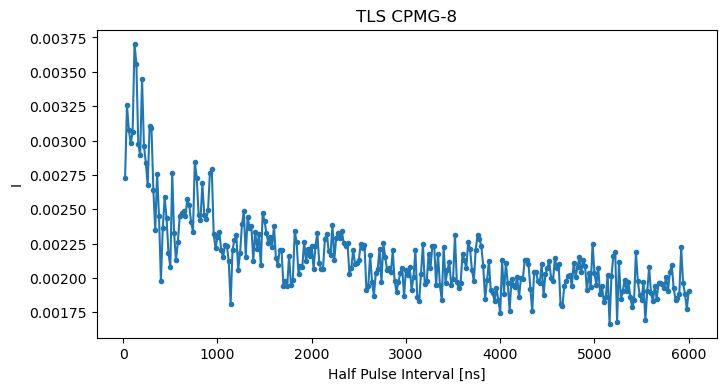

In [172]:
%matplotlib inline
expt_dataset = xr.load_dataset(r"Z:\QM_Data_DF5\2024\06\Data_0607\2024-06-07_q1t0_tls_cpmg8_3.nc")
expt_dataset['I'].plot(x=list(expt_dataset.coords.keys())[0], marker = '.')
plt.title(expt_dataset.attrs['long_name'])

### CPMG-12

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 46930.16s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 46930.21s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0630\2024-06-30_q3t3_tls_cpmg12_2


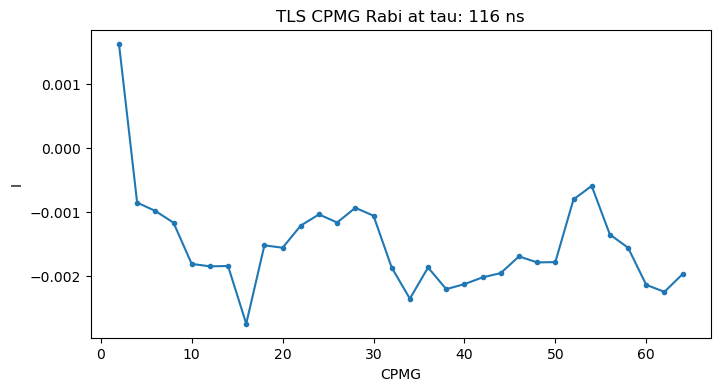

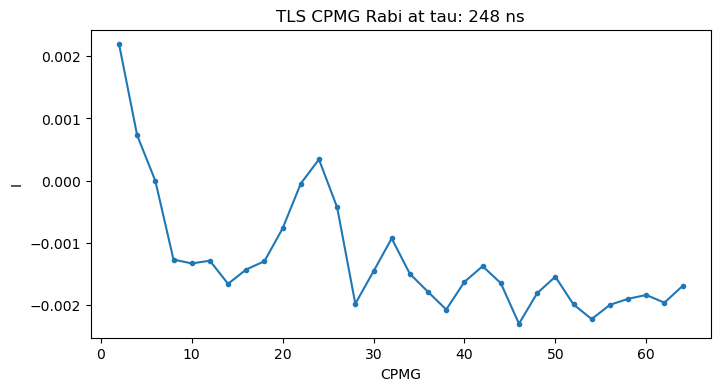

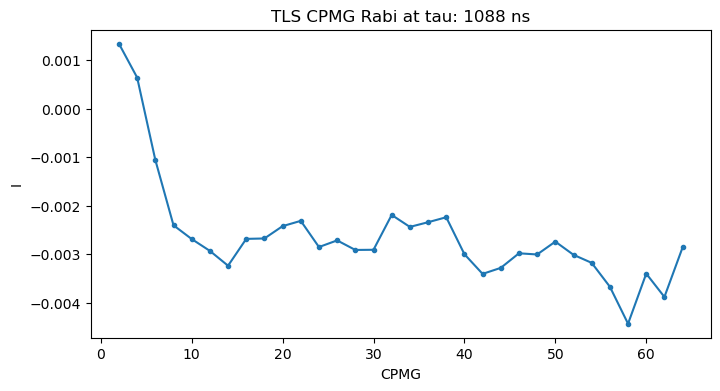

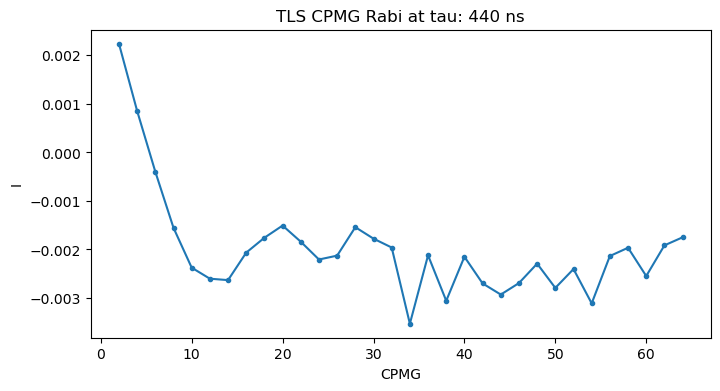

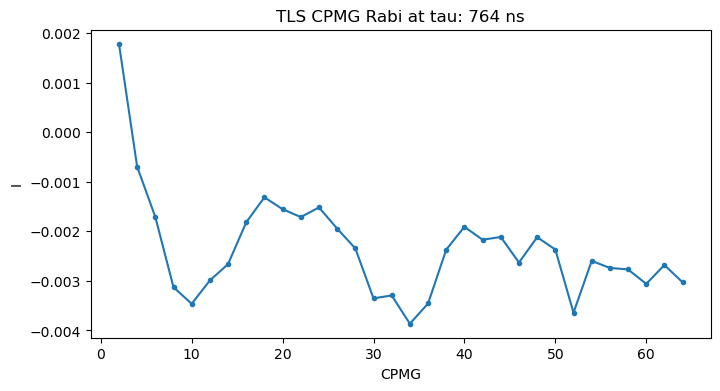

<Figure size 800x400 with 0 Axes>

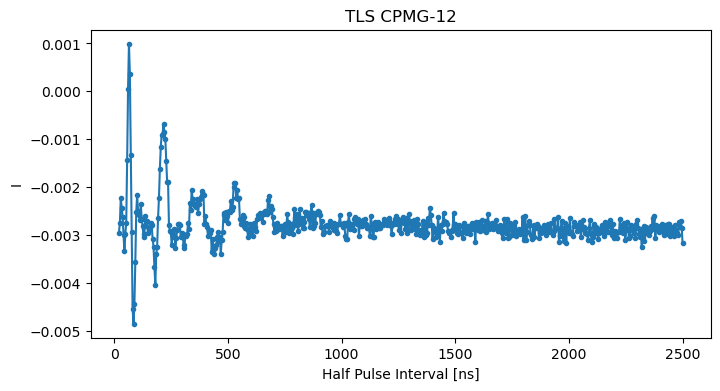

In [33]:
%matplotlib inline
N_CPMG = 12
tau_sweep_abs = np.arange(20, 2.5E3 + 0.1, 4)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 10E3, cd_time_qubit = 25E3, cd_time_TLS = 7500E3, live_plot = False)

### CPMG-16

In [173]:
%matplotlib inline
N_CPMG = 16
tau_sweep_abs = np.arange(20, 6E3 + 0.1, 20)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 200E3, live_plot = False)

KeyboardInterrupt: 

<Figure size 800x400 with 0 Axes>

In [ ]:
%matplotlib inline
expt_dataset = xr.load_dataset(r"Z:\QM_Data_DF5\2024\05\Data_0520\2024-05-20_q1t1_tls_cpmg16.nc")
expt_dataset['I'].plot(x=list(expt_dataset.coords.keys())[0], marker = '.')
plt.title(expt_dataset.attrs['long_name'])

### CPMG-32

In [ ]:
%matplotlib inline
N_CPMG = 32
tau_sweep_abs = np.arange(20, 6E3 + 0.1, 20)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 200E3, live_plot = False)

### CPMG-40

In [38]:
%matplotlib qt
N_CPMG = 40
tau_sweep_abs = np.arange(16, 1.2E3 + 0.1, 4)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 2E3, cd_time_qubit = 25E3, cd_time_TLS = 1500E3, live_plot = True)

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 937.50s
Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 937.53s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0521\2024-05-21_q1t1_tls_cpmg40
Execution stopped by user!


## CPMG Rabi

In [10]:
%matplotlib qt

N_CPMG_sweep = np.arange(2, 40 + 0.1, 2) 
tau = [116, 244, 436, 772, 836] # in units of ns

for t in tau:
    machine, expt_dataset = Experiment.exp1D.Rabi.TLS_CPMG_Rabi(machine, N_CPMG_sweep, t, qubit_index, TLS_index, 
                         n_avg = 5E3, cd_time_qubit = 25E3, cd_time_TLS = 7500E3)


Progress: [##################################################] 100.0% (n=20/20) --> elapsed time: 1719516835.35s
Elapsed duration 792.851404 s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0627\2024-06-27_q3t3_tls_cpmg_rabi116ns_6
Progress: [##################################################] 100.0% (n=20/20) --> elapsed time: 1719517627.76s
Elapsed duration 792.231246 s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0627\2024-06-27_q3t3_tls_cpmg_rabi244ns_5
Progress: [##################################################] 100.0% (n=20/20) --> elapsed time: 1719518419.66s
Elapsed duration 791.751334 s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0627\2024-06-27_q3t3_tls_cpmg_rabi436ns_2
Progress: [##################################################] 100.0% (n=20/20) --> elapsed time: 1719519213.04s
Elapsed duration 793.192657 s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0627\2024-06-27_q3t3_tls_cpmg_rabi772ns_2
Progress: [##################################################] 100.0% (n

In [13]:
%matplotlib qt

N_CPMG_sweep = np.arange(2, 40 + 0.1, 2) 
tau = 436
machine, expt_dataset = Experiment.exp1D.Rabi.TLS_CPMG_Rabi(machine, N_CPMG_sweep, tau, qubit_index, TLS_index, 
                         n_avg = 10E3, cd_time_qubit = 25E3, cd_time_TLS = 7500E3)

Progress: [##################################################] 100.0% (n=20/20) --> elapsed time: 1719524010.06s
Elapsed duration 1547.729816 s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0627\2024-06-27_q3t3_tls_cpmg_rabi436ns_3


In [136]:
%matplotlib qt


tau = [436] # in units of ns
N_CPMG_sweep = np.arange(2, 70 + 0.1, 2)

for t in tau:
    machine, expt_dataset = Experiment.exp1D.Rabi.TLS_CPMG_Rabi(machine, N_CPMG_sweep, t, qubit_index, TLS_index, 
                         n_avg = 20E3, cd_time_qubit = 25E3, cd_time_TLS = 7500E3)

Progress: [##################################################] 100.0% (n=35/35) --> elapsed time: 1720503177.29s
Elapsed duration 5363.807966 s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0708\2024-07-08_q3t3_tls_cpmg_rabi436ns


### Add spectroscopy checks after x averages

In [137]:
tau = [436]  # in units of ns
N_CPMG_sweep = np.arange(2, 70+0.1, 2)

n_avg = 20E3 # Number of total averages
delta_avg = 5E3 # After this amount of averages run a TLS spectroscopy to make sure the signal has not decayed
cd_time_qubit = 25E3
cd_time_TLS = 7500E3
runs = int(n_avg/delta_avg)

## In order to save the averaged data
expt_qubits = [machine.qubits[qubit_index].name]
expt_TLS = ['t'+str(TLS_index)] 
expt_extra = [ 'n_ave: ' + str(n_avg) + '-' + 'Qubit CD [ns]: ' + str(cd_time_qubit) + '-' + 'TLS CD [ns]: ' + str(cd_time_TLS)] # ALWAYS SEPARATE DIFFERENT ATTRIBUTES WITH A DASH (this is the delimiter)
expt_sequence = """for N_index, N_value in enumerate(N_CPMG_sweep):

			with program() as tls_cpmg_tau:
				[I, Q, n, I_st, Q_st, n_st] = declare_vars()
				t = declare(int)
				assign(t, tau)

				update_frequency(machine.qubits[qubit_index].name,
								 tls_if_freq)  # important, otherwise will use the if in configuration, calculated from f_01

				with for_(n, 0, n < n_avg, n + 1):
					with strict_timing_():
						if pi_over_2_phase == 'x':
							play("pi2_tls", machine.qubits[qubit_index].name)
						else:
							play("pi2y_tls", machine.qubits[qubit_index].name)

						wait(t, machine.qubits[qubit_index].name)

						for i in range(N_value - 1):
							play("pi_tls", machine.qubits[qubit_index].name)
							wait(t * 2, machine.qubits[qubit_index].name)

						play("pi_tls", machine.qubits[qubit_index].name)
						wait(t, machine.qubits[qubit_index].name)

						if pi_over_2_phase == 'x':
							play("pi2_tls", machine.qubits[qubit_index].name)
						else:
							play("pi2y_tls", machine.qubits[qubit_index].name)

					align()
					square_TLS_swap[0].run()
					align()
					readout_rotated_macro(machine.resonators[qubit_index].name, I, Q)
					wait(cd_time_qubit * u.ns, machine.resonators[qubit_index].name)
					save(I, I_st)
					save(Q, Q_st)
					align()
					square_TLS_swap[0].run(amp_array=[(machine.flux_lines[qubit_index].name, -1)])
					wait(cd_time_TLS * u.ns, machine.flux_lines[qubit_index].name)
					# reset_frame(machine.qubits[qubit_index].name)  # to avoid phase accumulation
					save(n, n_st)
 NOTE: THE AVERAGES ARE DONE SEQUENTIALLY TO UPDATE THE TLS FREQUENCY IN CASE IT CHANGED"""


for t in tau:
    datasets = []
    print('*****************RUNNING tau: ', t , 'ns*****************')
    timestamp_created = datetime.datetime.now()
    
    for n in np.arange(runs):
        print('Running average', n+1, 'out of ', runs)
        machine, expt_dataset = Experiment.exp1D.Rabi.TLS_CPMG_Rabi(machine, N_CPMG_sweep, t, qubit_index, TLS_index, 
                         n_avg = delta_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, final_plot = False)
        datasets.append(expt_dataset)
        
        # Run spectroscopy
        print('Running spectroscopy', n+1, 'out of ', runs)
        TLS_freq_sweep = machine.qubits[qubit_index].f_tls[TLS_index] + np.arange(-13E6,13E6+1,1E6)
        machine, expt_dataset_spec = Experiment.exp1D.Rabi.TLS_freq(machine, TLS_freq_sweep, qubit_index, TLS_index,
                          n_avg = 1E3, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, final_plot = False, live_plot = False, data_process_method = 'I')
        
        # Analyze spectrosocpy data to get the newest frequency 
        TLS_freq = Analysis.exp1D.peak_fit(expt_dataset_spec, to_plot= False,  method = "Gaussian", data_process_method = 'I')
        machine.qubits[qubit_index].f_tls[TLS_index] = TLS_freq + 0E6
        machine = Analysis.set_machine(machine)
        print('Set TLS frequency to', TLS_freq)
        
    dataset_tmp = xr.concat(datasets, dim='runs')
    dataset_ave = dataset_tmp.mean(dim='runs')
    timestamp_finished = datetime.datetime.now()
    expt_name = 'tls_cpmg_rabi' + str(t) + 'ns'
    expt_long_name = 'TLS CPMG Rabi at tau: ' + str(t) + ' ns'
    # save data
    expt_dataset = Experiment.datalogs.save(dataset_ave, machine, timestamp_created, timestamp_finished, expt_name, expt_long_name, expt_qubits, expt_TLS, expt_sequence, expt_extra = expt_extra)
    globals()[f'exp_dataset_cpmg_rabi_{t}ns'] = expt_dataset

*****************RUNNING tau:  436 ns*****************
Running average 1 out of  4
Progress: [##################################################] 100.0% (n=35/35) --> elapsed time: 1720504571.38s
Elapsed duration 1393.761478 s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0708\2024-07-08_q3t3_tls_cpmg_rabi436ns_2
Running spectroscopy 1 out of  4
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 202.99s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 203.04s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 203.08s
----------saved to Z:\QM_Data_DF5\2024\07\Data_0708\2024-07-08_q3t3_tls_spec_9
Set TLS frequency to 5046217053
Running average 2 out of  4
Progress: [##################################################] 100.0% (n=35/35) --> elapsed time: 1720506171.91s
Elapsed duration 1395.083024 s
----------saved to Z:\QM_Data_DF